# Sentiment Classification of Apple and Google Tweets Using NLP
By DS-PT II Group 6

## Introduction
The purpose of this project is to build a model that can rate the sentiment of a tweet based on its content. The data is from https://data.world/crowdflower/brands-and-product-emotions. It contains over 9000 tweets about Apple and Google products rated by humans as either postive, negative, or neutral.

This notebook contains



## Data Cleaning

### Importing libraries

In [102]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize




from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")



### Load the dataset

In [103]:
df = pd.read_csv('tweet_data.csv', encoding= 'latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [104]:
df.shape

(9093, 3)

From the above, we can see that the data is organized into 9093 rows and 3 columns: 
* tweet_text
* emotion_in_tweet_is_directed_at
* is_there_an_emotion_directed_at_a_brand_or_product

These column names are quite lengthy. Let's simplify them

In [105]:
# Change column names to be more user-friendly
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Device', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion'})

# Confirm the changes
df.head()
                        

,Tweet,Device,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [106]:
# Check for missing values 
print(df.isnull().sum())
# Check for duplicates
print(df.duplicated().sum())


Tweet         1
Device     5802
Emotion       0
dtype: int64
22


From the above, we see that there is 1 missing value in the 'Tweet' column, 5802 missing values in the 'Device' column and none in the 'Emotion' column. There are 22 duplicates.

We will proceed to drop the duplicates column and fill 'unknown' for the missing values in the device column. For the 1 missing value in the 'Tweet' column we will delete the entire row.

In [107]:
# Drop duplicates
df = df.drop_duplicates()
# Fill missing values in 'Device' column with 'unknown'
df['Device'] = df['Device'].fillna('unknown')
# Drop rows with missing values in 'Tweet' column
df = df.dropna(subset=['Tweet'])


In [108]:
# Confirm the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    9070 non-null   object
 1   Device   9070 non-null   object
 2   Emotion  9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


Let's take a look at the value counts within the emotion column to understand the relationship between positive, negative and neutral tweets.

In [109]:
df['Emotion'].value_counts()

Emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

As you can see in the cell above, there are 4 different types of sentiments expressed about the devices: 'No emotion toward brand or product', 'Positive emotion', 'Negative emotion' and 'I can't tell'.

These are too lengthy, so we will rename them into something more user-friendly.

Also, the first and last column are quite similar, so we will proceed to merge them into one.


In [110]:
# Merge 'No emotion toward brand or product' and 'I can't tell' into 'Neutral'
def clean_emotions(df, column): #Building function to change emotions
    emotion_list = [] #Making list for new names of emotions
    for i in df[column]:
        if i == "No emotion toward brand or product": #Renaming no emotions
            emotion_list.append('Neutral') #Renaming as Neutral
        elif i == "I can't tell": #Renaming I can't tell
            emotion_list.append('Neutral') #Renaming as Neutral
        elif i == "Positive emotion": #Renaming positive emotion
            emotion_list.append('Positive') #Renaming as Positive
        elif i == "Negative emotion": #Renaming negative emotion
            emotion_list.append('Negative') #Renaming as Negative
    df['Emotion'] = emotion_list #Setting column to new names
    return df

df = clean_emotions(df, 'Emotion') #Set df to clean emotions function
df['Emotion'].value_counts() #Checking value counts to see if they were changed

Emotion
Neutral     5531
Positive    2970
Negative     569
Name: count, dtype: int64

Let's take a look at the value counts within the device column to understand the column distribution

In [111]:
# 
df['Device'].value_counts()

Device
unknown                            5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64

The distribution across products is quite skewed. More than half of the tweets don’t reference a specific product. To address this, we plan to introduce a new column called “Brand”, which will indicate whether the tweet relates to Apple or Google, using the information already available in the “Product” column. Since the dataset focuses on these two companies, having this brand-level detail may prove useful later, so it makes sense to set it up now.

The process will be as follows: first, we’ll review all entries in the “Device” column. Next, we’ll write a function that goes through this column and assigns the appropriate brand to the new column. If the product is not specified, the function will then check the tweet text itself for product-related keywords. If no keywords are found, the brand will remain “Unknown.” If terms for both Apple and Google are detected, the entry will be labeled “Both.” The goal is to create more balanced classes for this new feature.

In [112]:
device_mapping = {
    "iPad": "Apple",
    "Apple": "Apple",
    "iPad or iPhone App": "Apple",
    "iPhone": "Apple",
    "Other Apple product or service": "Apple",
    
    "Google": "Google",
    "Other Google product or service": "Google",
    "Android": "Google",
    "Android App": "Google",
    
    "Unknown": "Unknown",
    
}

# Map first from the Device column
df["Brand"] = df["Device"].map(device_mapping).fillna("Unknown")

# Handle "Both" case if tweet mentions both Apple and Google/Android
df["Brand"] = df.apply(
    lambda row: "Both" if (
        ("apple" in str(row["Tweet"]).lower() or "ip" in str(row["Tweet"]).lower()) and
        ("google" in str(row["Tweet"]).lower() or "android" in str(row["Tweet"]).lower())
    ) else row["Brand"],
    axis=1
)

# Check final distribution
brand_distribution = df["Brand"].value_counts()
brand_distribution

Brand
Unknown    5575
Apple      2359
Google      836
Both        300
Name: count, dtype: int64

We also want to try and understand a few characteristics of the tweets. To acheive this, we will add 3 more columns to our dataset that will be useful for the exploratory data analysis (EDA) process: 
1. Tweet character count.
2. Hashtags.
3. Hashtag count.

In [113]:
def tweet_character_count(text_of_tweet): #Function to count characters in tweet
    return len(text_of_tweet.strip()) #Returns length of tweet

df['Tweet Character Count'] = df.apply(lambda row: tweet_character_count(row['Tweet']), axis = 1) #Making new column

df['Hashtag'] = df['Tweet'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) #Making hashtag column

df['Hashtag Count'] = df['Hashtag'].str.len() #Creating column with number of Hashtags used

# df['Clean'] = df['Tweet'] #New column for cleaned tweets

df.head() #Checking to see if columns were created accurately

,Tweet,Device,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"[#RISE_Austin, #SXSW]",2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,[#SXSW],1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"[#iPad, #SXSW]",2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,[#sxsw],1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,[#SXSW],1


### Text Pre-processing

Before we begin tokenisation, we need to omit the stopwords that exist within the tweets. This is because they are bulky datapoints that will only slow down our model. However, a realisation that words that convey negative sentiment is quickly apparent. We, therefore, need to take a look at the stopwords library to determine whether it is suitable.

In [114]:
ntlk_stopwords = stopwords.words('english')
print(nltk_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

It is clear that omitting all stopwords will get rid of negative sentiments within tweets. So, to address this issue, we will run code that keeps these stop words intact within the tweets.

In [115]:
# Load NLTK stopwords
stop_words = set(stopwords.words("english"))

# Define negation words you want to KEEP
negation_words = {"no", "not", "nor", "never", "none", "nobody", "nothing", "neither", "cannot", "n't"}

# Remove them from the stopword list
custom_stopwords = stop_words - negation_words

print("Default stopwords count:", len(stop_words))
print("Custom stopwords count:", len(custom_stopwords))
print("Negations preserved:",negation_words)

Default stopwords count: 198
Custom stopwords count: 195
Negations preserved: {'nothing', "n't", 'never', 'cannot', 'nor', 'no', 'not', 'none', 'nobody', 'neither'}


In order to turn a tweet into text data that can be modelled on NLP, we need to do the following:
1. Make everything lowercase
2. Remove all URLs or URL placeholder values
3. Remove all mentions and hashtags
4. Remove all characters that aren't letters
5. Remove all punctuation
6. Remove all extra spaces

In [131]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+|#', '', text)                                       # remove mentions & hashtags
    text = re.sub(r'\d+', '', text)                                          # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))         # remove punctuation
    text = re.sub(r'link', '', text)                                         # remove the word 'link'
    text = re.sub(r'rt', '', text)                                           # remove 'rt' (retweet indicator)

    tokens = nltk.word_tokenize(text)                                        # tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords]
    
    cleaned_text = " ".join(tokens)                                          # join back into string
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()                 # remove extra spaces
    
    return cleaned_text

In [132]:
# Apply preprocessing to the correct column
df["Clean_Tweet"] = df["Tweet"].apply(clean_text)

# Preview cleaned text
print(df[["Tweet", "Clean_Tweet"]].head())

                                               Tweet  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

                                         Clean_Tweet  
0  g iphone hr tweeting riseaustin dead need upgr...  
1  know awesome ipadiphone app youll likely appre...  
2                       not wait ipad also sale sxsw  
3  hope year festival isnt crashy year iphone app...  
4  great stuff fri sxsw marissa mayer google tim ...  


Now let us visualise our output following the pre-processing

In [133]:
df.head()

,Tweet,Device,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count,Clean_Tweet,word_count,char_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"[#RISE_Austin, #SXSW]",2,g iphone hr tweeting riseaustin dead need upgr...,10,64
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,[#SXSW],1,know awesome ipadiphone app youll likely appre...,13,84
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"[#iPad, #SXSW]",2,not wait ipad also sale sxsw,5,23
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,[#sxsw],1,hope year festival isnt crashy year iphone app...,8,46
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,[#SXSW],1,great stuff fri sxsw marissa mayer google tim ...,14,99


From this visualisation, we have ended up with a cleaned dataset that has organised our data into 8 columns. We have completed preprocessing the data.

### Exploratory Data Analysis

Having tokenised our tweets, we need to gain a clear understanding of the dataset. We will generate visuals to help with that. To help with that, let us visualise the head of the data to understand what categories we are dealing with.

In [134]:
df.head()

,Tweet,Device,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count,Clean_Tweet,word_count,char_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"[#RISE_Austin, #SXSW]",2,g iphone hr tweeting riseaustin dead need upgr...,10,64
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,[#SXSW],1,know awesome ipadiphone app youll likely appre...,13,84
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"[#iPad, #SXSW]",2,not wait ipad also sale sxsw,5,23
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,[#sxsw],1,hope year festival isnt crashy year iphone app...,8,46
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,[#SXSW],1,great stuff fri sxsw marissa mayer google tim ...,14,99


The first visual we will generate is the distribution of emotions.

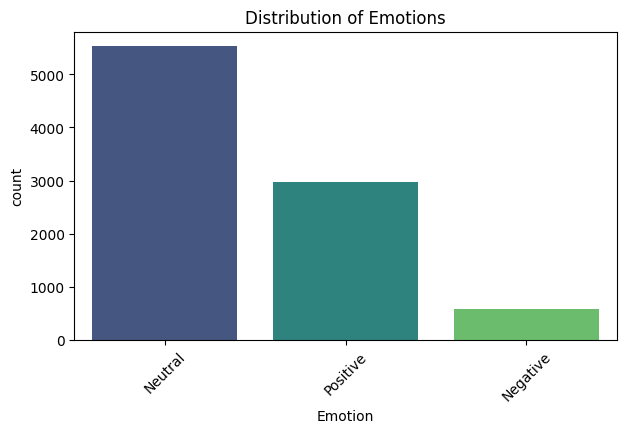

In [135]:
plt.figure(figsize=(7,4))
sns.countplot(x="Emotion", data=df, order=df["Emotion"].value_counts().index, palette="viridis")
plt.title("Distribution of Emotions")
plt.xticks(rotation=45)
plt.show()

Next, we will visualise the distribution of brands and emotions therein.

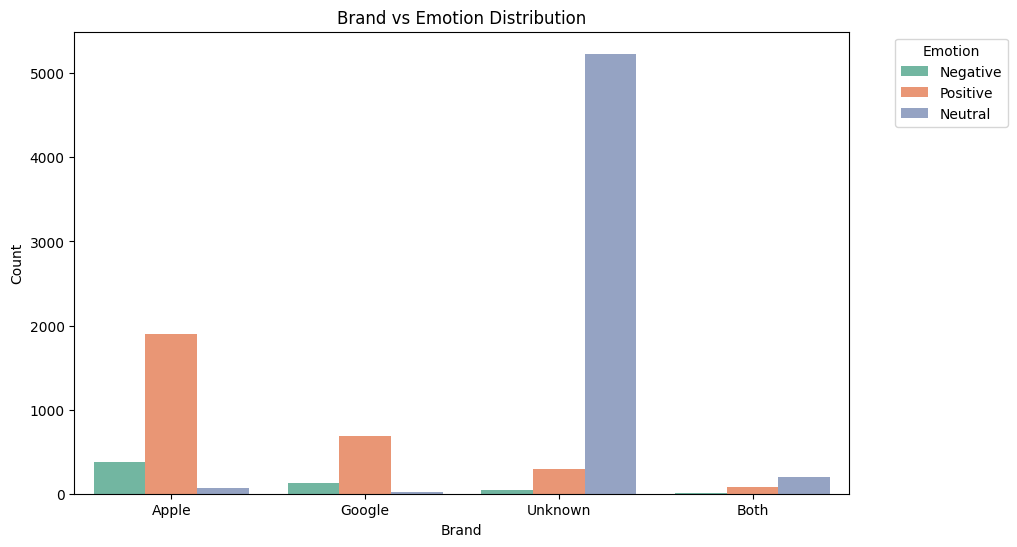

In [136]:
plt.figure(figsize=(10,6))
sns.countplot(x="Brand", hue="Emotion", data=df, palette="Set2")
plt.title("Brand vs Emotion Distribution")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Next, we will take a look at tweet length

In [137]:
df["word_count"] = df["Clean_Tweet"].apply(lambda x:len(str(x).split()))
df["char_count"] = df["Clean_Tweet"].apply(lambda x:len(str(x)))

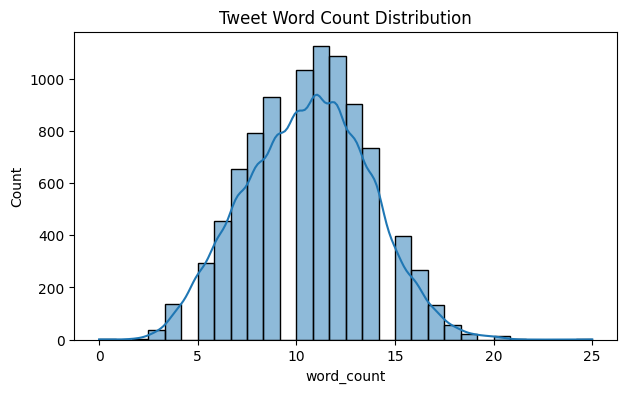

In [138]:
plt.figure(figsize=(7,4))
sns.histplot(df["word_count"], bins=30, kde=True)
plt.title("Tweet Word Count Distribution")
plt.show()

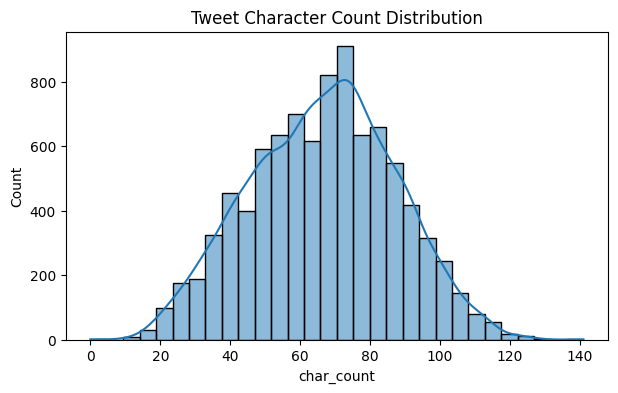

In [139]:
plt.figure(figsize=(7,4))
sns.histplot(df["char_count"], bins=30, kde=True)
plt.title("Tweet Character Count Distribution")
plt.show()

Next, we will generate visuals based on the text we are using. 

In [140]:
from collections import Counter

def get_top_n_words(corpus, n=20):
    words = " ".join(corpus).split()
    common_words = Counter(words).most_common(n)
    return pd.DataFrame(common_words, columns=["Word", "Frequency"])

print("\nTop words overall:\n", get_top_n_words(df["Clean_Tweet"],20))


Top words overall:
        Word  Frequency
0      sxsw       9433
1      ipad       2865
2    google       2506
3     apple       2241
4    iphone       1515
5     store       1503
6       new       1082
7    austin        960
8       app        811
9       amp        717
10   launch        681
11   social        634
12   circle        629
13    popup        599
14    today        567
15  android        565
16      not        525
17  network        465
18      get        454
19     line        441


In [141]:
!pip install wordcloud


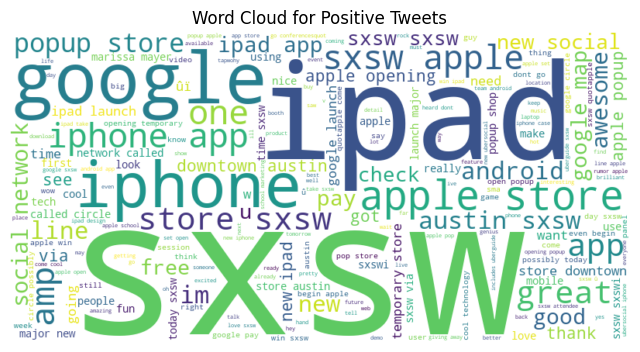

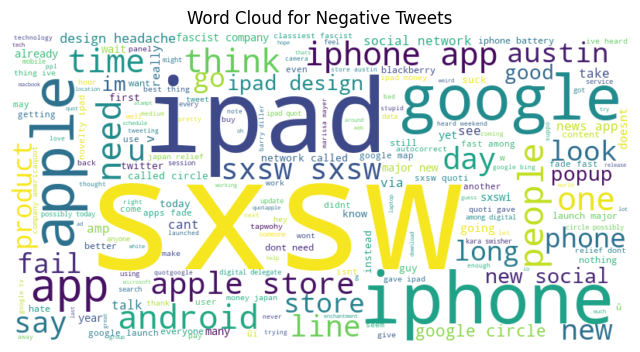

In [142]:
# Wordcloud for positive vs negative tweets

from wordcloud import WordCloud
for emotion in ["Positive", "Negative"]:
    text = " ".join(df[df["Emotion"]==emotion]["Clean_Tweet"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {emotion} Tweets")
plt.show()

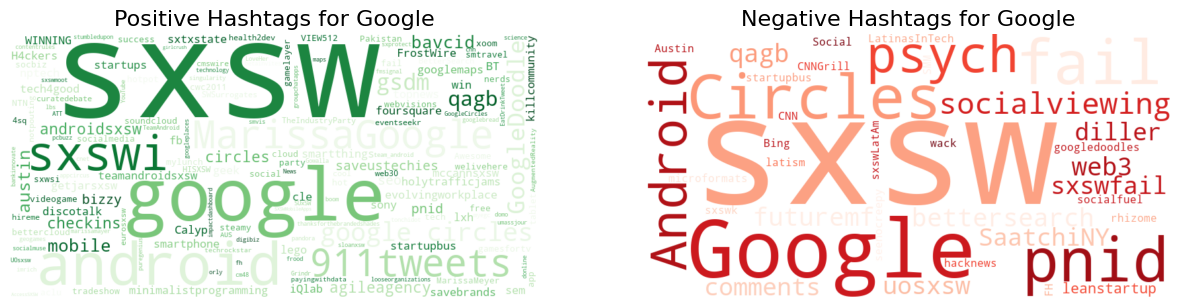

In [143]:
# Filter Google tweets only
google_df = df[df["Brand"].str.lower() == "google"]

# Function to flatten hashtags
def flatten_hashtags(series):
    hashtags = []
    for item in series.dropna():
        if isinstance(item, list):  # if hashtags are stored as lists
            hashtags.extend(item)
        else:  # if single string
            hashtags.append(item)
    return " ".join(hashtags)

# Positive hashtags
positive_hashtags = flatten_hashtags(
    google_df[google_df["Emotion"].str.lower() == "positive"]["Hashtag"]
)

# Negative hashtags
negative_hashtags = flatten_hashtags(
    google_df[google_df["Emotion"].str.lower() == "negative"]["Hashtag"]
)

# Generate word clouds
plt.figure(figsize=(15, 7))

# Positive
plt.subplot(1, 2, 1)
wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_hashtags)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Hashtags for Google", fontsize=16)

# Negative
plt.subplot(1, 2, 2)
wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_hashtags)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Hashtags for Google", fontsize=16)

plt.show()

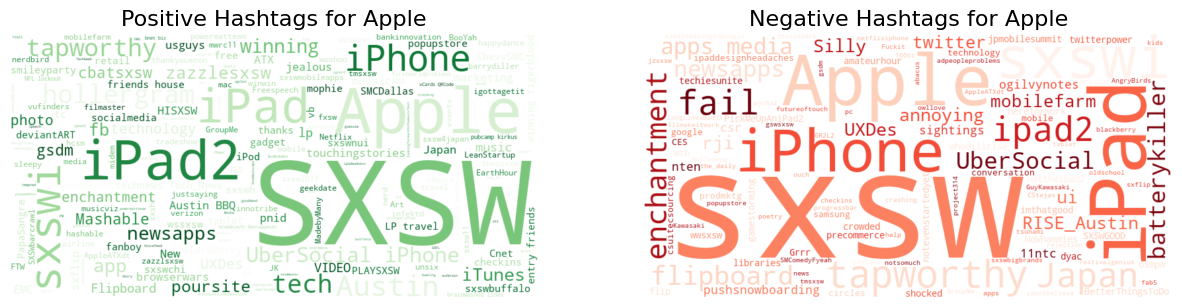

In [144]:
# Filter Apple tweets only
apple_df = df[df["Brand"].str.lower() == "apple"]

# Function to flatten hashtags
def flatten_hashtags(series):
    hashtags = []
    for item in series.dropna():
        if isinstance(item, list):  # if hashtags are stored as lists
            hashtags.extend(item)
        else:  # if single string
            hashtags.append(item)
    return " ".join(hashtags)

# Positive hashtags
positive_hashtags = flatten_hashtags(
    apple_df[apple_df["Emotion"].str.lower() == "positive"]["Hashtag"]
)

# Negative hashtags
negative_hashtags = flatten_hashtags(
    apple_df[apple_df["Emotion"].str.lower() == "negative"]["Hashtag"]
)

# Generate word clouds
plt.figure(figsize=(15, 7))

# Positive
plt.subplot(1, 2, 1)
wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_hashtags)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Hashtags for Apple", fontsize=16)

# Negative
plt.subplot(1, 2, 2)
wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_hashtags)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Hashtags for Apple", fontsize=16)

plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


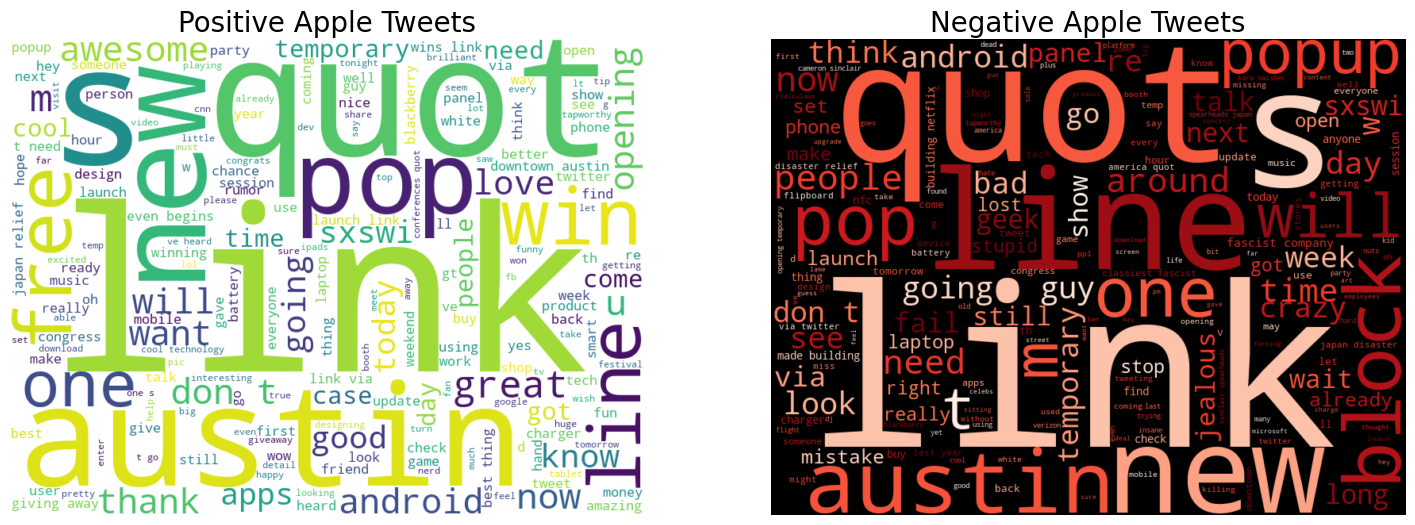

In [ ]:
# Sentiment Analysis for Positive & Negative Apple Tweets 

import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon once
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# FILTER FOR APPLE BRAND 
apple_terms = r"\b(apple|iphone|ipad|macbook|mac|imac|ios|applewatch|airpods|vision pro|app store)\b"
df_apple = df[df['Tweet'].str.contains(apple_terms, flags=re.I, na=False)].copy()

# CLEAN TEXT
df_apple["clean"] = df_apple["Tweet"].map(clean_tweet)

# SENTIMENT SCORES
df_apple["compound"] = df_apple["clean"].map(lambda x: sia.polarity_scores(x)["compound"] if isinstance(x, str) else 0.0)
df_pos = df_apple[df_apple["compound"] >= 0.05]
df_neg = df_apple[df_apple["compound"] <= -0.05]

# STOPWORDS (extend with Apple terms so they don’t dominate)
extra_stops = {
    "apple","iphone","ipad","mac","macbook","imac","ios","watch","applewatch",
    "app","store","airpods","vision","pro","rt","https","http","co","amp"
}
stops = STOPWORDS.union(extra_stops)

# BUILD WORDCLOUDS
text_pos = " ".join(df_pos["clean"].dropna())
text_neg = " ".join(df_neg["clean"].dropna())

wc_pos = WordCloud(width=800, height=600, background_color="white",
                   stopwords=stops, max_words=200).generate(text_pos)

wc_neg = WordCloud(width=800, height=600, background_color="black",
                   stopwords=stops, colormap="Reds", max_words=200).generate(text_neg)

# PLOT SIDE BY SIDE
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].imshow(wc_pos, interpolation='bilinear')
axs[0].set_title("Positive Apple Tweets", fontsize=20)
axs[0].axis("off")

axs[1].imshow(wc_neg, interpolation='bilinear')
axs[1].set_title("Negative Apple Tweets", fontsize=20)
axs[1].axis("off")

plt.show()

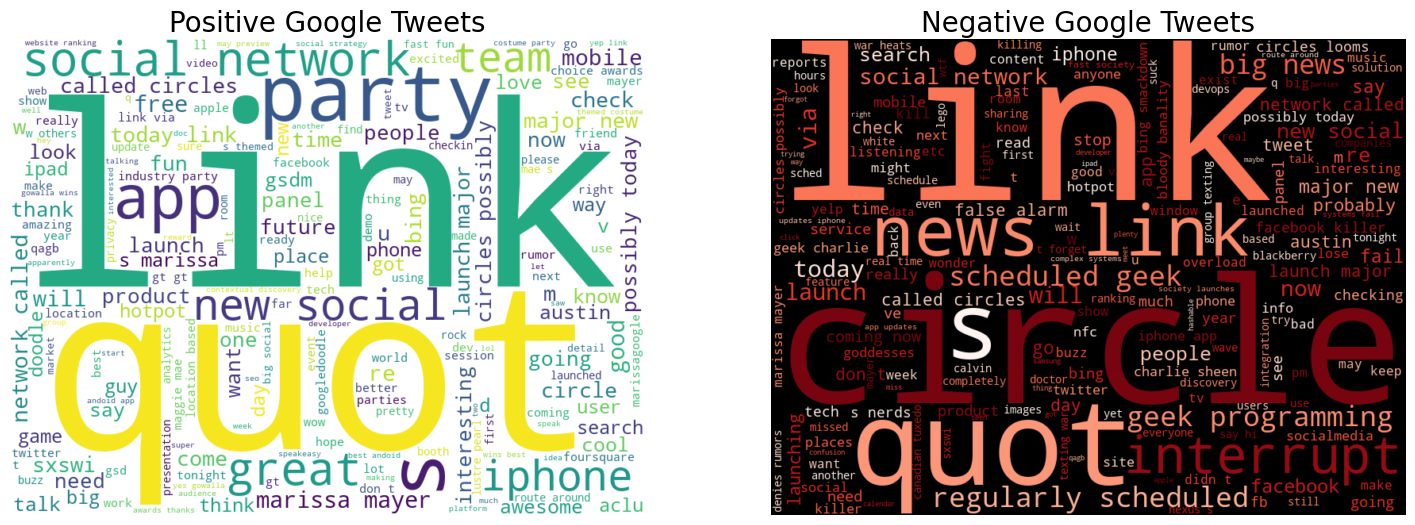

In [147]:
# FILTER FOR GOOGLE BRAND
google_terms = r"\b(google|android|pixel|gmail|chrome|chromebook|chromecast|googleplay|google drive|youtube|maps)\b"
df_google = df[df['Tweet'].str.contains(google_terms, flags=re.I, na=False)].copy()

# CLEAN TEXT
df_google["clean"] = df_google["Tweet"].map(clean_tweet)

# SENTIMENT SCORES
df_google["compound"] = df_google["clean"].map(lambda x: sia.polarity_scores(x)["compound"] if isinstance(x, str) else 0.0)
df_pos_g = df_google[df_google["compound"] >= 0.05]
df_neg_g = df_google[df_google["compound"] <= -0.05]

# STOPWORDS (extend with Google terms so they don’t dominate)
extra_stops_g = {
    "google","android","pixel","gmail","chrome","chromebook","chromecast","googleplay",
    "play","store","youtube","maps","drive","photos","rt","https","http","co","amp"
}
stops_g = STOPWORDS.union(extra_stops_g)

# BUILD WORDCLOUDS
text_pos_g = " ".join(df_pos_g["clean"].dropna())
text_neg_g = " ".join(df_neg_g["clean"].dropna())

wc_pos_g = WordCloud(width=800, height=600, background_color="white",
                     stopwords=stops_g, max_words=200).generate(text_pos_g)

wc_neg_g = WordCloud(width=800, height=600, background_color="black",
                     stopwords=stops_g, colormap="Reds", max_words=200).generate(text_neg_g)

# PLOT SIDE BY SIDE
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].imshow(wc_pos_g, interpolation='bilinear')
axs[0].set_title("Positive Google Tweets", fontsize=20)
axs[0].axis("off")

axs[1].imshow(wc_neg_g, interpolation='bilinear')
axs[1].set_title("Negative Google Tweets", fontsize=20)
axs[1].axis("off")

plt.show()

This marks the end of our Exploratory Data Analysis (EDA). We will now progress to the next stage.

### Modelling